In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve, roc_auc_score, accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, average_precision_score, log_loss
from sklearn.ensemble import GradientBoostingClassifier

2024-02-29 01:28:19.133684: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
root_folder = "/Users/alvaroleal/Desktop/DS/Zrive"

df_feature_frame = pd.read_csv(root_folder + '/feature_frame.csv')
df_feature_frame.head()

,variant_id,product_type,order_id,user_id,created_at,order_date,user_order_seq,outcome,ordered_before,abandoned_before,...,count_children,count_babies,count_pets,people_ex_baby,days_since_purchase_variant_id,avg_days_to_buy_variant_id,std_days_to_buy_variant_id,days_since_purchase_product_type,avg_days_to_buy_product_type,std_days_to_buy_product_type
0,33826472919172,ricepastapulses,2807985930372,3482464092292,2020-10-05 16:46:19,2020-10-05 00:00:00,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
1,33826472919172,ricepastapulses,2808027644036,3466586718340,2020-10-05 17:59:51,2020-10-05 00:00:00,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
2,33826472919172,ricepastapulses,2808099078276,3481384026244,2020-10-05 20:08:53,2020-10-05 00:00:00,4,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
3,33826472919172,ricepastapulses,2808393957508,3291363377284,2020-10-06 08:57:59,2020-10-06 00:00:00,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
4,33826472919172,ricepastapulses,2808429314180,3537167515780,2020-10-06 10:37:05,2020-10-06 00:00:00,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618


In [3]:
min_products = 5
order_size = df_feature_frame.groupby('order_id')['outcome'].sum()
orders_of_min_size = order_size[order_size >= min_products].index
df_filtered = df_feature_frame[df_feature_frame['order_id'].isin(orders_of_min_size)]

In [4]:
info_cols = ['variant_id', 'order_id', 'user_id', 'created_at', 'order_date']
label_col = 'outcome'
features_cols = [col for col in df_filtered.columns if col not in info_cols + [label_col]]

categorical_cols = ['product_type', 'vendor']
binary_cols = ['ordered_before', 'abandoned_before', 'active_snoozed', 'set_as_regular']
numerical_cols = [col for col in features_cols if col not in categorical_cols + binary_cols]

In [5]:
df_filtered = df_filtered.sort_values('created_at')

order_ids = df_filtered['order_id'].unique()

total_ids = len(order_ids)
train_end = int(total_ids * 0.7)
val_end = train_end + int(total_ids * 0.15)

train_order_ids = order_ids[:train_end]
val_order_ids = order_ids[train_end:val_end]
test_order_ids = order_ids[val_end:]

train_df = df_filtered[df_filtered['order_id'].isin(train_order_ids)]
val_df = df_feature_frame[df_feature_frame['order_id'].isin(val_order_ids)]
test_df = df_feature_frame[df_feature_frame['order_id'].isin(test_order_ids)]

print(f"Train set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")

Train set size: 1446691
Validation set size: 347233
Test set size: 370029


In [6]:
def feature_label_split(df, label_col):
    return df.drop(label_col, axis=1), df[label_col]

X_train, y_train = feature_label_split(train_df, label_col)
X_val, y_val = feature_label_split(val_df, label_col)
X_test, y_test = feature_label_split(test_df, label_col)

In [14]:
"""""Función para crear los gráficos del performance de nuestro modelo"""
def plot_metrics(model_name, y_pred, y_test, figsize=(10, 7)):
    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    pr_auc = auc(recall, precision)
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    accuracy = accuracy_score(y_test.astype(np.int64), np.rint(y_pred).astype(np.int64))
    conf_matrix = confusion_matrix(y_test.astype(np.int64), np.rint(y_pred).astype(np.int64))

    fig, ax = plt.subplots(2, 2, figsize=figsize)  # 2x2 para incluir la matriz de confusión

    ax[0, 0].plot(recall, precision, label=f"{model_name} AUC: {pr_auc:.2f}")
    ax[0, 0].set_xlabel("Recall")
    ax[0, 0].set_ylabel("Precision")
    ax[0, 0].set_title(f"Precision-Recall Curve")
    ax[0, 0].legend()

    ax[0, 1].plot(fpr, tpr, label=f"AUC: {roc_auc:.2f}")
    ax[0, 1].set_xlabel("FPR")
    ax[0, 1].set_ylabel("TPR")
    ax[0, 1].set_title(f"ROC Curve")
    ax[0, 1].legend()

    ax[1, 0].axis('off')  # No se necesita eje para mostrar texto
    ax[1, 0].text(0.5, 0.5, f"Accuracy: {accuracy:.2f}", fontsize=15, ha='center')

    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', ax=ax[1, 1])
    ax[1, 1].set_title("Confusion Matrix")
    ax[1, 1].set_xlabel("Predicted label")
    ax[1, 1].set_ylabel("True label")

    plt.tight_layout()
    plt.show()
    print("Precision Recall AUC: " + str(pr_auc))
    print("Roc Curve AUC: " + str(roc_auc))
    print("Sum of both AUCs: " + str(pr_auc + roc_auc))

In [8]:
"""""Función para ver la importancia de los coeficientes"""
def plot_feature_importance(clf, columns):
    fig, ax = plt.subplots()
    fi = pd.DataFrame(list(zip(columns, clf.feature_importances_)), columns=["features", "importance"])
    fi.sort_values(by="importance", ascending=True, inplace=True)
    fi.plot(kind="barh", x="features", y="importance", ax=ax)
    return fig, ax

## Previous Baselines

### Initial Benchmark 

Para nuestra evaluación inicial, utilizamos la característica de "popularidad global" para determinar si el pedido puede ser realizado o no.

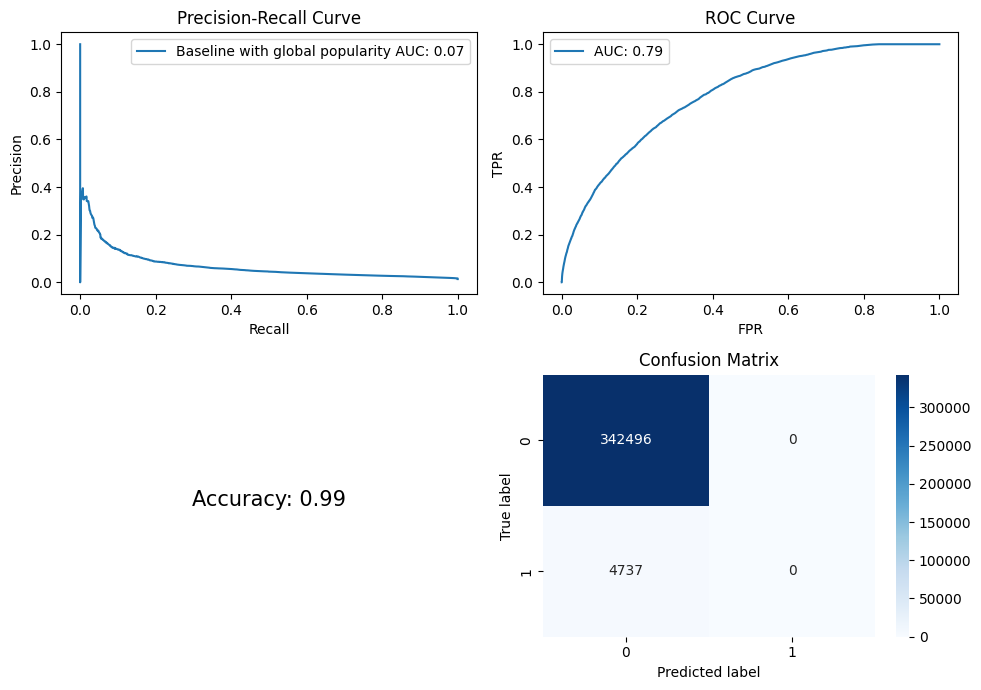

In [10]:
plot_metrics("Baseline with global popularity",val_df["global_popularity"],val_df[label_col])

### Best Linear models result

Para nuestra segunda evaluación, emplearemos el modelo lineal que mostró mejores resultados en el ejercicio anterior: regresión Lasso sin variables categóricas, eliminando variables con una importancia menor a 0.02.

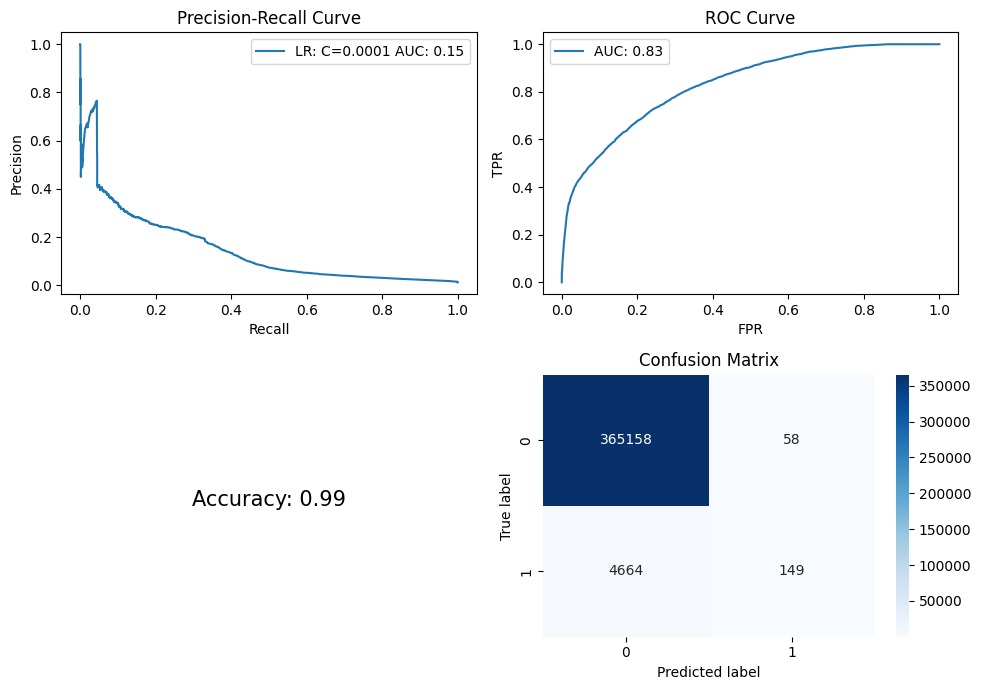

Precision Recall AUC: 0.14909622626798194
Roc Curve AUC: 0.8321347472511265


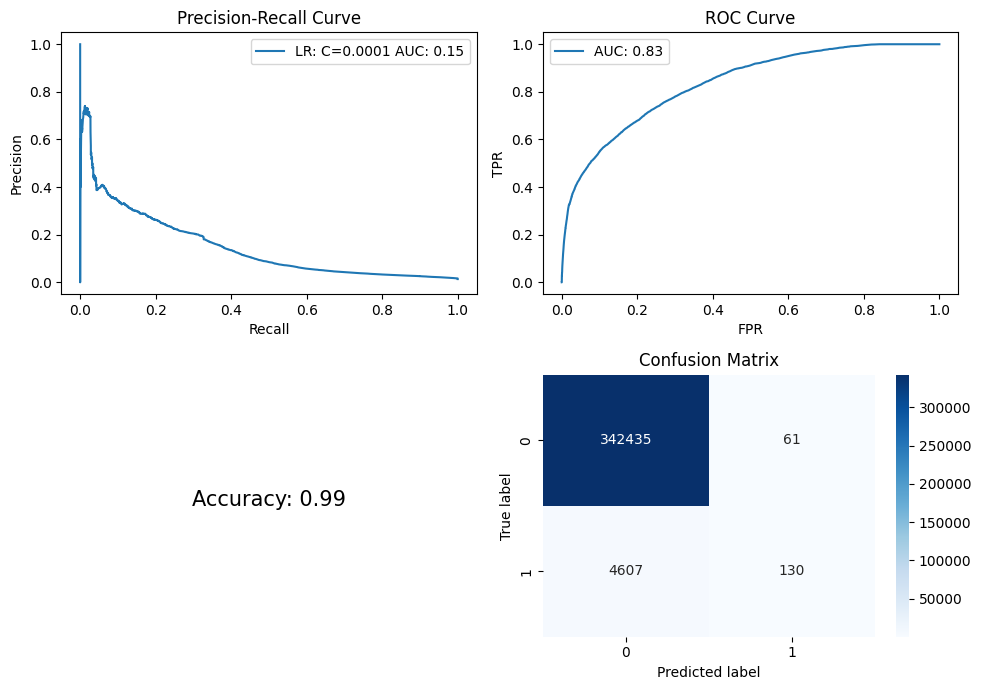

Precision Recall AUC: 0.14868719039041456
Roc Curve AUC: 0.8348974327812615


In [28]:
train_cols = ["days_since_purchase_variant_id", "discount_pct", "std_days_to_buy_product_type", "count_pets", "set_as_regular", "avg_days_to_buy_product_type", "days_since_purchase_product_type", "user_order_seq", "avg_days_to_buy_variant_id", "abandoned_before", "global_popularity", "normalised_price", "ordered_before",]

regularization_values = [1e-4, 1e-3, 1e-2, 1e-1, 1, 10]

best_auc = 0
best_c = None
best_model = None

for c in regularization_values:
    lr = make_pipeline(
        StandardScaler(),
        LogisticRegression(penalty='l1',C=c, solver='liblinear')
    )
    lr.fit(X_train[train_cols], y_train)

    y_proba = lr.predict_proba(X_test[train_cols])[:, 1]
    
    roc_auc = roc_auc_score(y_test, y_proba)
    
    if roc_auc > best_auc:
        best_auc = roc_auc
        best_c = c
        best_model = lr

y_pred = best_model.predict_proba(X_test[train_cols])[:, 1]

plot_metrics(f"LR: C={best_c}", y_pred, y_test)

y_pred = best_model.predict_proba(X_val[train_cols])[:, 1]

plot_metrics(f"LR: C={best_c}", y_pred, y_val)

## Non Linear Models

El propósito de este ejercicio es superar los resultados que logramos con nuestro mejor modelo lineal de la semana pasada, utilizando modelos no lineales. Con estos modelos no lineales, pretendemos aumentar la complejidad de nuestro modelo con el objetivo de mejorar su rendimiento.

Para empezar, desarrollaremos dos modelos:  Random Forest y Gradient Boosting Trees

## Random Forest

Comenzaremos iterando los diferentes parámetros de nuestro modelo para determinar los valores óptimos para nuestro conjunto de datos.

In [37]:
train_cols = numerical_cols + binary_cols

n_trees_grid = [5, 25, 50, 100]

metrics = {
    'n_trees': [],
    'train_auc': [],
    'val_auc': [],
    'train_ap': [],
    'val_ap': [],
    'train_ce': [],
    'val_ce': []
}

for n_trees in n_trees_grid:
    rf = RandomForestClassifier(n_estimators=n_trees)
    rf.fit(X_train[train_cols], y_train)
    
    train_probs = rf.predict_proba(X_train[train_cols])[:, 1]
    val_probs = rf.predict_proba(X_val[train_cols])[:, 1]
    
    metrics['n_trees'].append(n_trees)
    metrics['train_auc'].append(roc_auc_score(y_train, train_probs))
    metrics['val_auc'].append(roc_auc_score(y_val, val_probs))
    metrics['train_ap'].append(average_precision_score(y_train, train_probs))
    metrics['val_ap'].append(average_precision_score(y_val, val_probs))
    metrics['train_ce'].append(log_loss(y_train, train_probs))
    metrics['val_ce'].append(log_loss(y_val, val_probs))

print("Métricas:")
for i in range(len(n_trees_grid)):
    print(f"# Trees: {metrics['n_trees'][i]}")
    print(f"Train AUC: {metrics['train_auc'][i]:.4f}, Validation AUC: {metrics['val_auc'][i]:.4f}")
    print(f"Train AP: {metrics['train_ap'][i]:.4f}, Validation AP: {metrics['val_ap'][i]:.4f}")
    print(f"Train Cross Entropy: {metrics['train_ce'][i]:.4f}, Validation Cross Entropy: {metrics['val_ce'][i]:.4f}")
    print()

Métricas:
# Trees: 5
Train AUC: 0.9909, Validation AUC: 0.6442
Train AP: 0.7707, Validation AP: 0.0707
Train Cross Entropy: 0.0243, Validation Cross Entropy: 0.3497

# Trees: 25
Train AUC: 0.9952, Validation AUC: 0.7161
Train AP: 0.8524, Validation AP: 0.1128
Train Cross Entropy: 0.0209, Validation Cross Entropy: 0.2489

# Trees: 50
Train AUC: 0.9955, Validation AUC: 0.7302
Train AP: 0.8598, Validation AP: 0.1185
Train Cross Entropy: 0.0207, Validation Cross Entropy: 0.2231

# Trees: 100
Train AUC: 0.9957, Validation AUC: 0.7484
Train AP: 0.8628, Validation AP: 0.1248
Train Cross Entropy: 0.0206, Validation Cross Entropy: 0.1915



Tras ejecutar este código, podemos observar los siguientes aspectos:

- La elevada precisión obtenida en el conjunto de entrenamiento es un resultado esperado, considerando que estamos implementando un modelo de bosque aleatorio.
- Se constata una mejora considerable en el rendimiento del modelo con el aumento en el número de árboles. Aunque sería factible continuar ajustando este parámetro, experimentando con valores como 150 o 200, las restricciones de tiempo nos llevan a establecer 100 como el número óptimo de árboles.

### Model 1. Random Forest - Without categorical variables

Iniciaremos el entrenamiento de un primer modelo utilizando los parámetros previamente seleccionados y enfocándonos únicamente en las variables numéricas. Por el momento, excluiremos las variables categóricas debido a su complejidad.

In [39]:
train_cols = numerical_cols + binary_cols

n_trees = 100

rf = RandomForestClassifier(n_estimators=n_trees)
rf.fit(X_train[train_cols], y_train)

train_probs = rf.predict_proba(X_train[train_cols])[:, 1]
test_probs = rf.predict_proba(X_test[train_cols])[:, 1]
val_probs = rf.predict_proba(X_val[train_cols])[:, 1]

print(f"Train_auc: {roc_auc_score(y_train, train_probs)}")
print(f"Val_auc {roc_auc_score(y_val, val_probs)}")
print(f"Train_ap {average_precision_score(y_train, train_probs)}")
print(f"Val_ap {average_precision_score(y_val, val_probs)}")
print(f"Train_ce {log_loss(y_train, train_probs)}")
print(f"Val_ce {log_loss(y_val, val_probs)}")

plot_metrics("Random_Forest_2", test_probs, y_test)
plot_metrics("Random_Forest_2", val_probs, y_val)

RandomForestClassifier()

(<Figure size 640x480 with 1 Axes>, <Axes: ylabel='features'>)

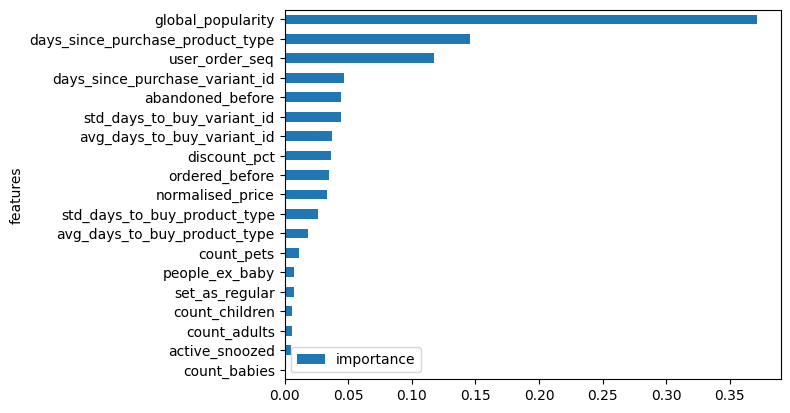

In [41]:
plot_feature_importance(rf, train_cols)

### Model 2: Random Forest - Without categorical variables - variables with importance > 0.02

La distribución de la importancia de los coeficientes en nuestro modelo no parece equilibrada. Por tanto, procederemos a desarrollar un nuevo modelo simplificado, descartando aquellos coeficientes que presenten una importancia inferior a 0.02.

Train_auc: 0.9951735546753651
Val_auc 0.7437482863079924
Train_ap 0.8479491372821064
Val_ap 0.110158456175734
Train_ce 0.021404713671575235
Val_ce 0.18508661408635912


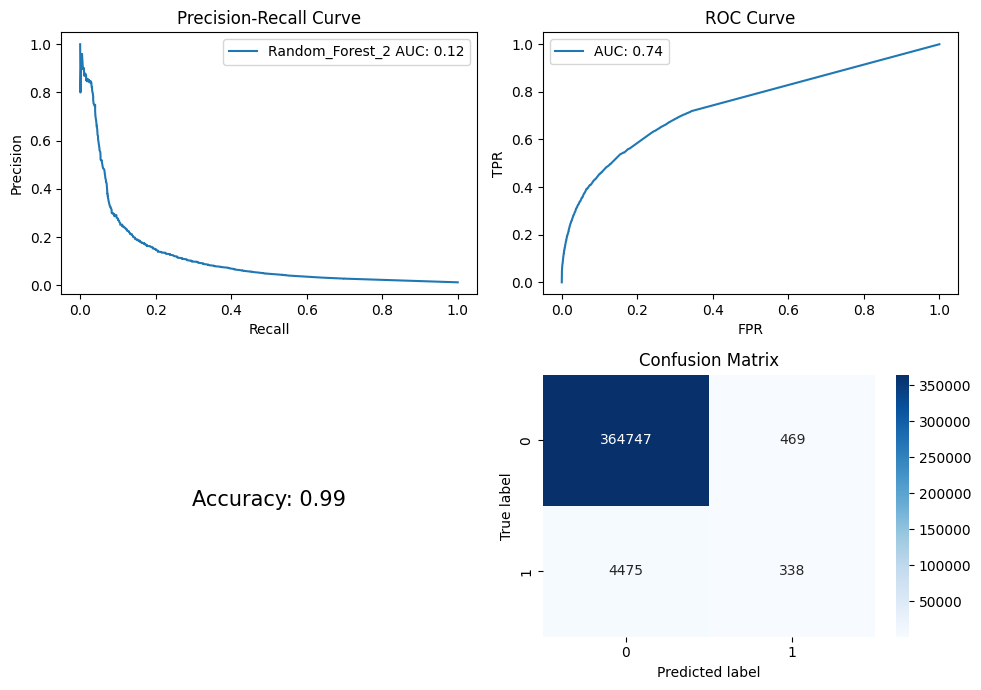

Precision Recall AUC: 0.11948090674617384
Roc Curve AUC: 0.7434437365377136


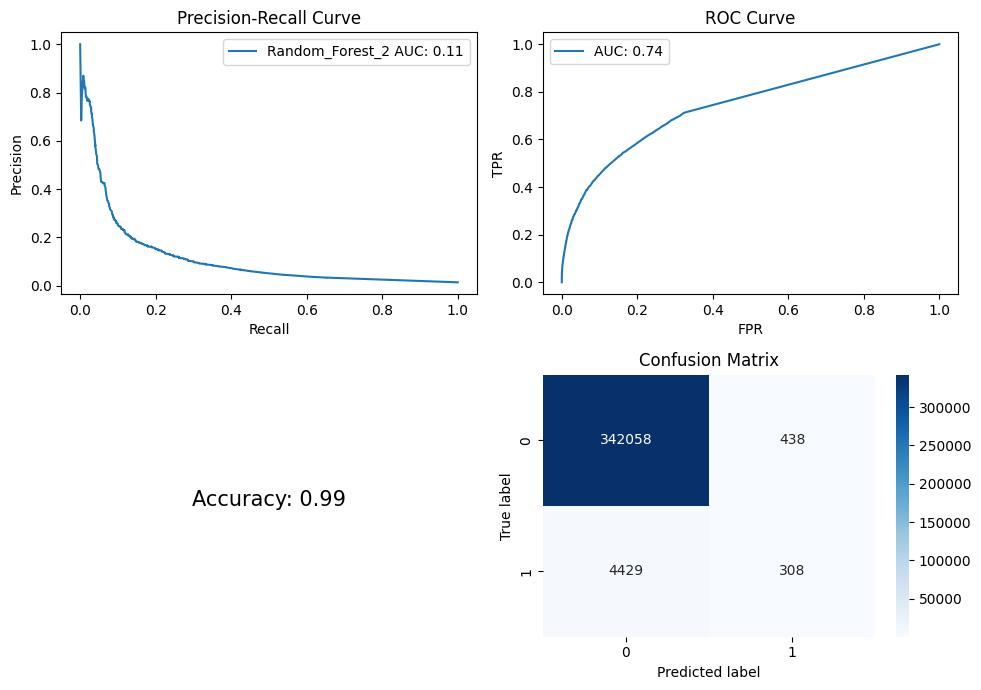

Precision Recall AUC: 0.11331897652079789
Roc Curve AUC: 0.7437482863079924


In [22]:
train_cols = ["global_popularity", "days_since_purchase_product_type", "user_order_seq", "days_since_purchase_variant_id", "abandoned_before", "std_days_to_buy_variant_id", "avg_days_to_buy_variant_id", "discount_pct", "normalised_price", "ordered_before", "std_days_to_buy_product_type"]

n_trees = 100

rf_2 = RandomForestClassifier(n_estimators=n_trees)
rf_2.fit(X_train[train_cols], y_train)
    
train_probs = rf_2.predict_proba(X_train[train_cols])[:, 1]
test_probs = rf_2.predict_proba(X_test[train_cols])[:, 1]
val_probs = rf_2.predict_proba(X_val[train_cols])[:, 1]

print(f"Train_auc: {roc_auc_score(y_train, train_probs)}.",f"Val_auc {roc_auc_score(y_val, val_probs)}")
print(f"Train_ap {average_precision_score(y_train, train_probs)}.",f"Val_ap {average_precision_score(y_val, val_probs)}")
print(f"Train_ce {log_loss(y_train, train_probs)}.",f"Val_ce {log_loss(y_val, val_probs)}")

plot_metrics("Random_Forest_2", test_probs, y_test)
plot_metrics("Random_Forest_2", val_probs, y_val)

(<Figure size 640x480 with 1 Axes>, <Axes: ylabel='features'>)

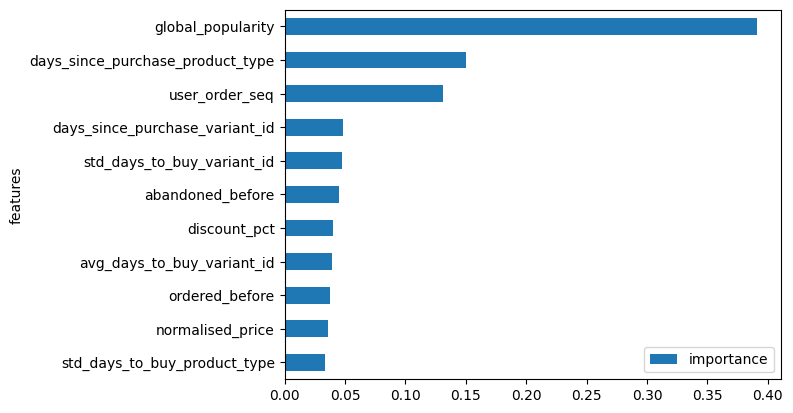

In [23]:
plot_feature_importance(rf_2, train_cols)

Parece que, en este modelo específico, la eliminación de los coeficientes con menor importancia no ha tenido un impacto significativo.

## Gradient Boosting Trees

Para continuar avanzando con la práctica, experimentaremos con modelos de Gradient Boosting Trees, utilizando los modelos anteriores como punto de referencia. Comenzaremos ajustando los distintos parámetros de nuestro modelo para identificar la configuración más óptima. Para simplificar el proceso, fijaremos el número de árboles en 100 como valor predeterminado para el modelo, ya que realizar iteraciones como en ocasiones anteriores consume demasiado tiempo.

In [39]:
train_cols = numerical_cols + binary_cols

learning_rates = [0.05, 0.1]
max_depths = [1, 3, 5]
n_trees_grid = [100] 

for lr in learning_rates:
    for depth in max_depths:
        for n_trees in n_trees_grid:
        
            gbt = GradientBoostingClassifier(learning_rate=lr, max_depth=depth, n_estimators=n_trees)
            gbt.fit(X_train[train_cols], y_train)

            train_probs = gbt.predict_proba(X_train[train_cols])[:, 1]
            val_probs = gbt.predict_proba(X_val[train_cols])[:, 1]
            
            print(f"LR: {lr} , max depth: {depth} , trees: {n_trees}")
            print(f"Train_auc: {roc_auc_score(y_train, train_probs)}.",f"Val_auc {roc_auc_score(y_val, val_probs)}")
            print(f"Train_ap {average_precision_score(y_train, train_probs)}.",f"Val_ap {average_precision_score(y_val, val_probs)}")
            print(f"Train_ce {log_loss(y_train, train_probs)}.",f"Val_ce {log_loss(y_val, val_probs)}")
            print()

LR: 0.05 , max depth: 1 , trees: 100
Train_auc: 0.8301458956930725. Val_auc 0.8312186637150558
Train_ap 0.16767192049564272. Val_ap 0.16223106879171462
Train_ce 0.06426211044693811. Val_ce 0.059000992051593364

LR: 0.05 , max depth: 3 , trees: 100
Train_auc: 0.8396903084216806. Val_auc 0.8435452272727766
Train_ap 0.19778186825699245. Val_ap 0.19022340151152622
Train_ce 0.06199000435585811. Val_ce 0.05672782580877858

LR: 0.05 , max depth: 5 , trees: 100
Train_auc: 0.8435100171277288. Val_auc 0.8463572394225133
Train_ap 0.21953226676443446. Val_ap 0.1920676485067287
Train_ce 0.06103491979394085. Val_ce 0.056399081302549184

LR: 0.1 , max depth: 1 , trees: 100
Train_auc: 0.8358799708210739. Val_auc 0.8393641217200688
Train_ap 0.17593635436885469. Val_ap 0.16857991236789077
Train_ce 0.06316355392672933. Val_ce 0.057949011320279666

LR: 0.1 , max depth: 3 , trees: 100
Train_auc: 0.8429258459731755. Val_auc 0.8461584590391725
Train_ap 0.20318960813263492. Val_ap 0.18849142908995345
Train_ce

Tras esta iteración, hemos determinado los parámetros más óptimos en términos de tasa de aprendizaje (learning rate) y profundidad (depth) para nuestros modelos. Ahora procederemos a entrenar nuestros modelos de Gradient Boosting Trees utilizando estos parámetros seleccionados.

### Model 3: Gradient Boosting Three - Without categorical variables

Siguiendo la misma estrategia empleada con los modelos anteriores, iniciaremos el entrenamiento de un modelo excluyendo las variables categóricas.

Train_auc: 0.8435100171277288. Val_auc 0.8463536274974822
Train_ap 0.21953226676443446. Val_ap 0.1919927932412116
Train_ce 0.06103491979394085. Val_ce 0.05640256031956773


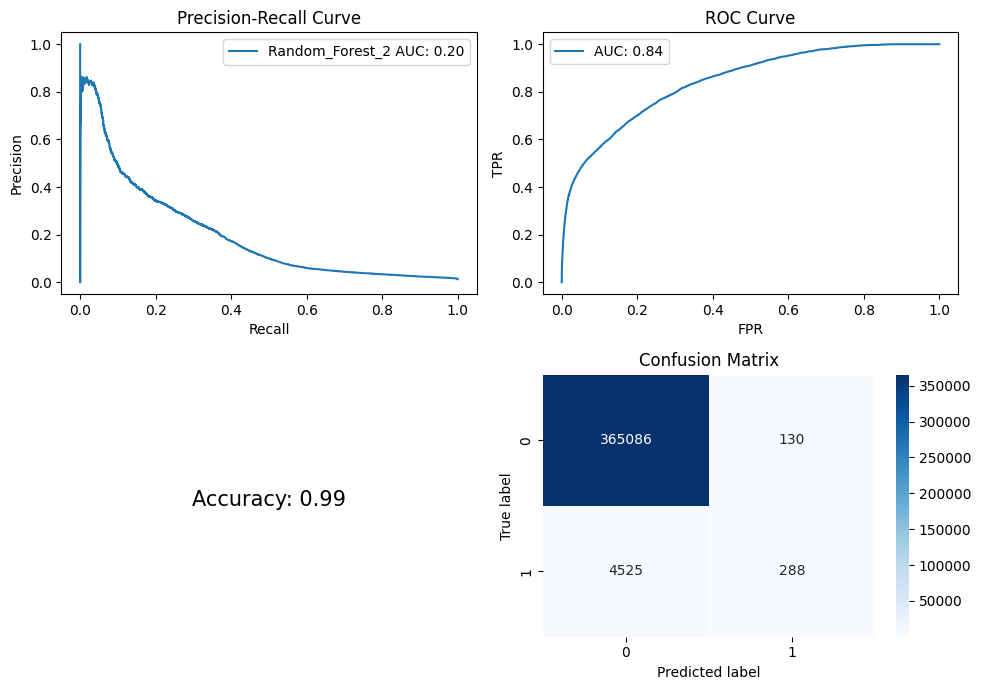

Precision Recall AUC: 0.19890975902943264
Roc Curve AUC: 0.844747437906795
Sum of both AUCs: 1.0436571969362276


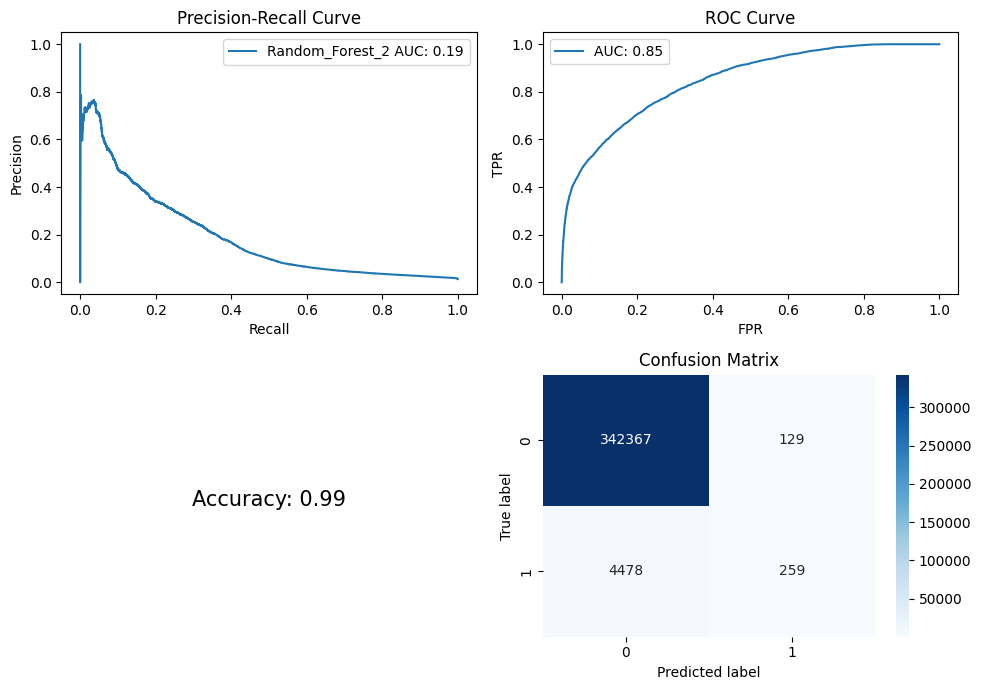

Precision Recall AUC: 0.19178290046990729
Roc Curve AUC: 0.8463536274974822
Sum of both AUCs: 1.0381365279673895


In [16]:
train_cols = numerical_cols + binary_cols

lr = 0.05
depth = 5
n_trees = 100

gbt = GradientBoostingClassifier(learning_rate=lr, max_depth=depth, n_estimators=n_trees)
gbt.fit(X_train[train_cols], y_train)

train_probs = gbt.predict_proba(X_train[train_cols])[:, 1]
test_probs = gbt.predict_proba(X_test[train_cols])[:, 1]
val_probs = gbt.predict_proba(X_val[train_cols])[:, 1]

print(f"Train_auc: {roc_auc_score(y_train, train_probs)}.",f"Val_auc {roc_auc_score(y_val, val_probs)}")
print(f"Train_ap {average_precision_score(y_train, train_probs)}.",f"Val_ap {average_precision_score(y_val, val_probs)}")
print(f"Train_ce {log_loss(y_train, train_probs)}.",f"Val_ce {log_loss(y_val, val_probs)}")

plot_metrics("Random_Forest_2", test_probs, y_test)
plot_metrics("Random_Forest_2", val_probs, y_val)

(<Figure size 640x480 with 1 Axes>, <Axes: ylabel='features'>)

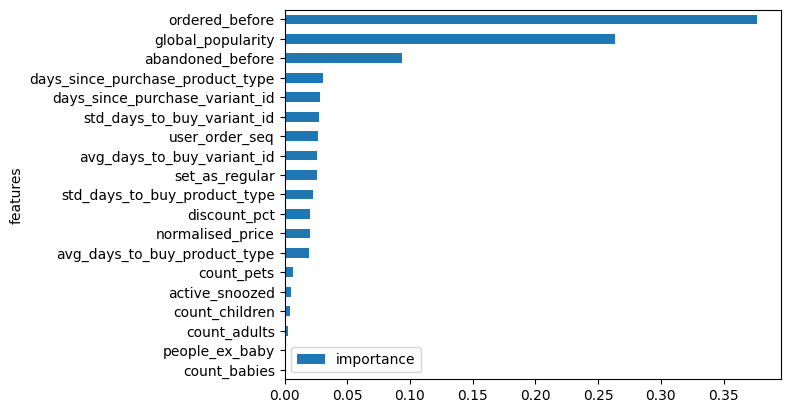

In [41]:
plot_feature_importance(gbt, train_cols)

### Model 4: Gradient Boosting Three - Without categorical variables - variables with importance > 0.02

Intentaremos mejorar nuestro modelo una vez más al reducir su complejidad, eliminando aquellos coeficientes que resulten menos significativos.

Train_auc: 0.843473214235045. Val_auc 0.846327982213392
Train_ap 0.21841262473539977. Val_ap 0.19257618354668404
Train_ce 0.06105798499900578. Val_ce 0.0563746229992203


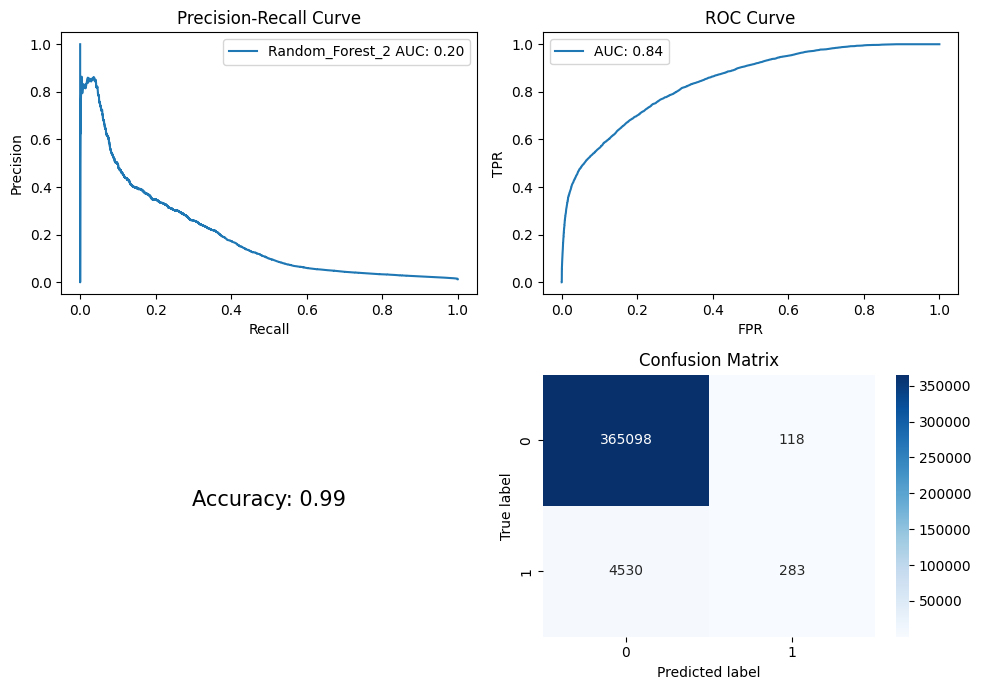

Precision Recall AUC: 0.1992181888589764
Roc Curve AUC: 0.8448881570818715
Sum of both AUCs: 1.044106345940848


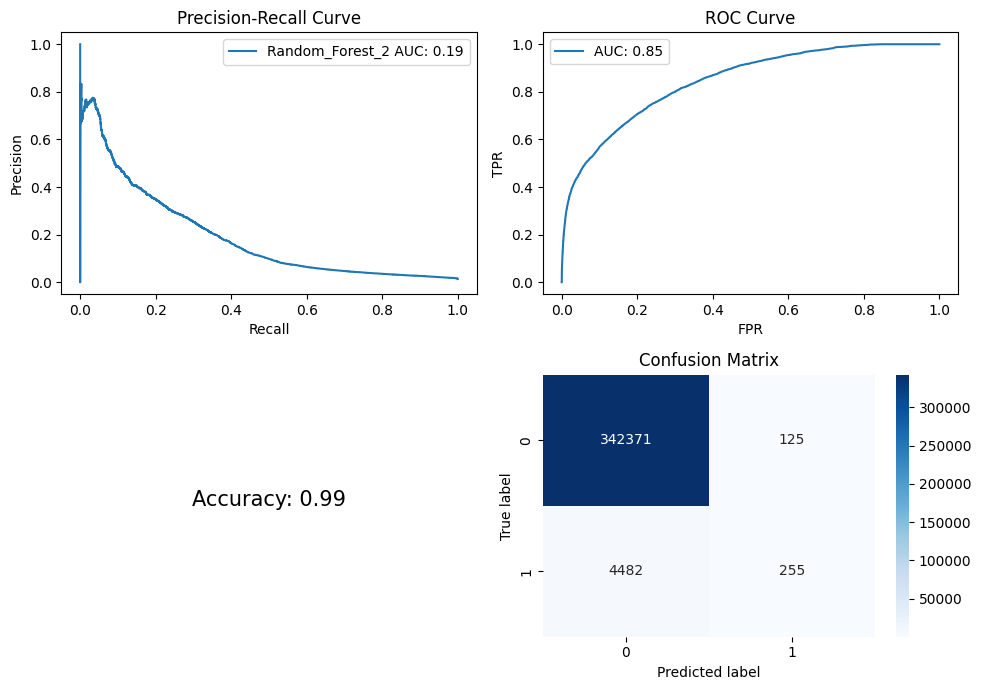

Precision Recall AUC: 0.19235713920249017
Roc Curve AUC: 0.846327982213392
Sum of both AUCs: 1.038685121415882


In [17]:
train_cols = ["global_popularity", "days_since_purchase_product_type", "user_order_seq", "days_since_purchase_variant_id", "abandoned_before", "std_days_to_buy_variant_id", "avg_days_to_buy_variant_id", "set_as_regular", "discount_pct", "normalised_price", "ordered_before", "std_days_to_buy_product_type", "avg_days_to_buy_product_type"]

lr = 0.05
depth = 5
n_trees = 100

gbt = GradientBoostingClassifier(learning_rate=lr, max_depth=depth, n_estimators=n_trees)
gbt.fit(X_train[train_cols], y_train)

train_probs = gbt.predict_proba(X_train[train_cols])[:, 1]
test_probs = gbt.predict_proba(X_test[train_cols])[:, 1]
val_probs = gbt.predict_proba(X_val[train_cols])[:, 1]

print(f"Train_auc: {roc_auc_score(y_train, train_probs)}.",f"Val_auc {roc_auc_score(y_val, val_probs)}")
print(f"Train_ap {average_precision_score(y_train, train_probs)}.",f"Val_ap {average_precision_score(y_val, val_probs)}")
print(f"Train_ce {log_loss(y_train, train_probs)}.",f"Val_ce {log_loss(y_val, val_probs)}")

plot_metrics("Random_Forest_2", test_probs, y_test)
plot_metrics("Random_Forest_2", val_probs, y_val)

(<Figure size 640x480 with 1 Axes>, <Axes: ylabel='features'>)

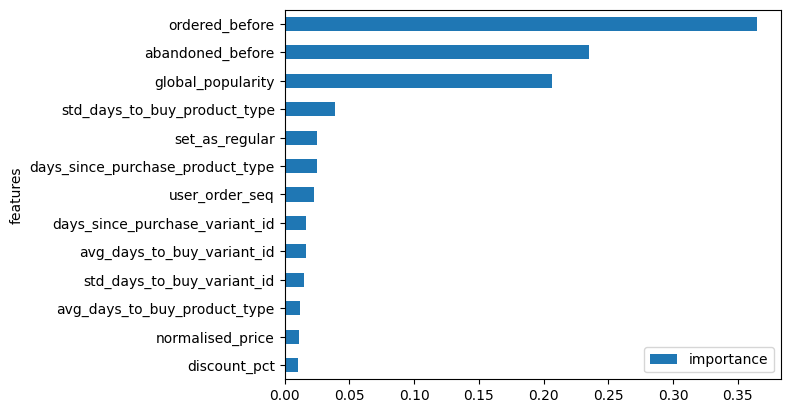

In [11]:
plot_feature_importance(gbt, train_cols)

Con la implementación y optimización de este último modelo, hemos logrado superar todos los puntos de referencia anteriores establecidos por nuestros modelos previos en el conjunto de datos de validación.

## Conclusion:
- Establecimiento de Benchmarks Claros: Iniciamos el proceso estableciendo puntos de referencia claros con resultados específicos a superar, lo que nos proporcionó objetivos definidos desde el principio.

- Importancia de Iterar sobre Parámetros Específicos: Me gustaría resaltar la importancia de iterar sobre los distintos parámetros específicos de cada modelo antes de comenzar a añadir o eliminar variables. De esta manera, podemos asegurarnos de que el modelo base esté optimizado y tenga el mejor rendimiento posible con la estructura de datos actual.

- Random Forest: Al construir nuestro modelo de Random Forestacercándonos a superar los benchmarks establecidos por los modelos lineales pero sin éxito. Este resultado podría atribuirse a la naturaleza intrínseca de los datos, a que solamente hemos trabajado con variables numéricas o las configuraciones específicas adoptadas para el modelo.

- Éxito con los Modelos de Gradient Boosting Trees (GBT): Logramos una mejora significativa y superamos nuestros benchmarks mediante la implementación de modelos de Gradient Boosting Trees. Este éxito no solo demostró la eficacia de los modelos no lineales para nuestro conjunto de datos sino que también resultó en un modelo simplificado y más eficiente. Al reducir la complejidad y enfocarnos en las variables más significativas, pudimos mejorar la interpretabilidad sin sacrificar el rendimiento.

- Como aspectos a mejorar, me gustaría haber indagado más en el preprocesamiento de variables numéricas, como hicimos en la práctica anterior con StandardScaler, y haber incluido posibles variables categóricas que podrían contener información relevante.